# DIABLO, Integration of multi-omics data

This is an adaptation of this vignette: https://bioconductor.org/packages/release/bioc/vignettes/mixOmics/inst/doc/vignette.html
mixOmics package tutorials here: http://mixomics.org/

Data were preprocessed for participants first measurement of each omic. 

There is a lot of fine tuning that could be done if we want to showcase this analysis.


In [122]:
options(jupyter.plot_scale=1,
        width=200,
        repr.matrix.max.cols=200,
        repr.matrix.max.rows=Inf)

In [123]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(mixOmics))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(caTools))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library("BiocParallel"))

set.seed(99)

In [124]:
# Read in baseline measures
### NOTE DIABLO can be run with repeated measures
prots <- read_delim("../data/prot_baseline.csv", delim=",")
mets <- read_delim("../data/mets_baseline.csv", delim=",")
clin <- read_delim("../data/clinical_baseline.csv", delim=",")

print(dim(mets))
print(dim(prots))
print(dim(clin))

frailty <- read_delim("../data/frailty/combination_fi_040124.csv", delim=",")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  public_client_id = col_character()
)
ℹ Use `spec()` for the full column specifications.


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  public_client_id = col_character(),
  `100001538(lidocaine)` = col_logical(),
  `100002719(cotinine N-oxide)` = col_logical(),
  `100003442(paroxetine)` = col_logical(),
  `100009253(mycophenolic acid)` = col_logical()
)
ℹ Use `spec()` for the full column specifications.

Warning message:
“4 parsing failures.
 row                          col           expected            actual                         file
1059 100003442(paroxetine)

[1] 2033 1051
[1] 2842 1196
[1] 4879  129


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  public_client_id = col_character(),
  sex = col_character(),
  race = col_character()
)
ℹ Use `spec()` for the full column specifications.



In [125]:
# Light filtering of missing values per row/colum

mets_filt <- mets[, colMeans(is.na(mets)) <= .15]
prots_filt <- prots[, colMeans(is.na(prots)) <= .15]
clin_filt <- clin[, colMeans(is.na(clin)) <= .15]
print(dim(mets_filt))
print(dim(prots_filt))
print(dim(clin_filt))

mets_filt <- mets_filt[rowMeans(is.na(mets_filt)) <= .15,]
prots_filt <- prots_filt[rowMeans(is.na(prots_filt)) <= .15,]
clin_filt <- clin_filt[rowMeans(is.na(clin_filt)) <= .15,]
print(dim(mets_filt))
print(dim(prots_filt))
print(dim(clin_filt))


## Diablo uses NIPALS for imputation.
## Diablo centers and scaled data.

[1] 2033  779
[1] 2842  275
[1] 4879   48
[1] 2009  779
[1] 2842  275
[1] 4828   48


In [126]:
# Merge to get participants with all measures
#put all data frames into list
df_list <- list(frailty, mets_filt, prots_filt, clin_filt)

#merge all data frames in list
combined_df <- df_list %>% reduce(inner_join, by = "public_client_id")

dim(combined_df)

[1]  891 1182

In [127]:
# Split into "blocks" for DIABLO
metabolites <- combined_df[,colnames(combined_df) %in% colnames(mets_filt)]
proteins <- combined_df[,colnames(combined_df) %in% colnames(prots_filt)]
clinical <- combined_df[,colnames(combined_df) %in% colnames(clin_filt)]
frailty <- combined_df[, c("public_client_id", "sex", "age", "race", "self_fi", "lab_fi", "merge_fi")]
# DIABLO can only be run with categorical variables 
# Split frailty measures into quintiles
frailty <- frailty %>%
  dplyr::mutate(lab_quantile = dplyr::ntile(lab_fi, 5),
                self_quantile = dplyr::ntile(self_fi, 5),
                merge_quantile = dplyr::ntile(merge_fi, 5))

In [128]:
table(frailty$sex)


  F   M 
572 319 

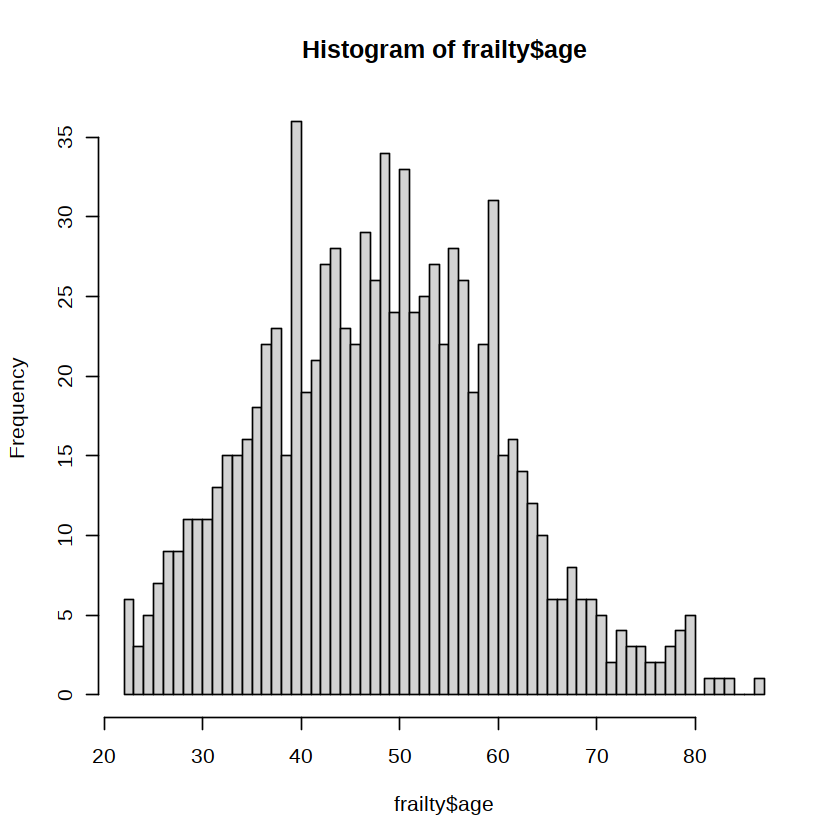

In [129]:
hist(frailty$age, breaks=50)

In [130]:
# Check rows are in the same order
all(frailty$public_client_id == metabolites$public_client_id)
all(frailty$public_client_id == proteins$public_client_id)
all(frailty$public_client_id == clinical$public_client_id)

[1] TRUE

[1] TRUE

[1] TRUE

# Single -omic (s)pls analysis

Using full data for the exploratory analysis. We should consider breaking into test/train to get out of sample prediction. 

In [131]:
Outcome <- as.factor(frailty$merge_quantile)
mets_mat <- as.matrix(metabolites[,2:ncol(metabolites)])
prots_mat <- as.matrix(metabolites[,2:ncol(proteins)])
clin_mat <- as.matrix(metabolites[,2:ncol(clinical)])
                 

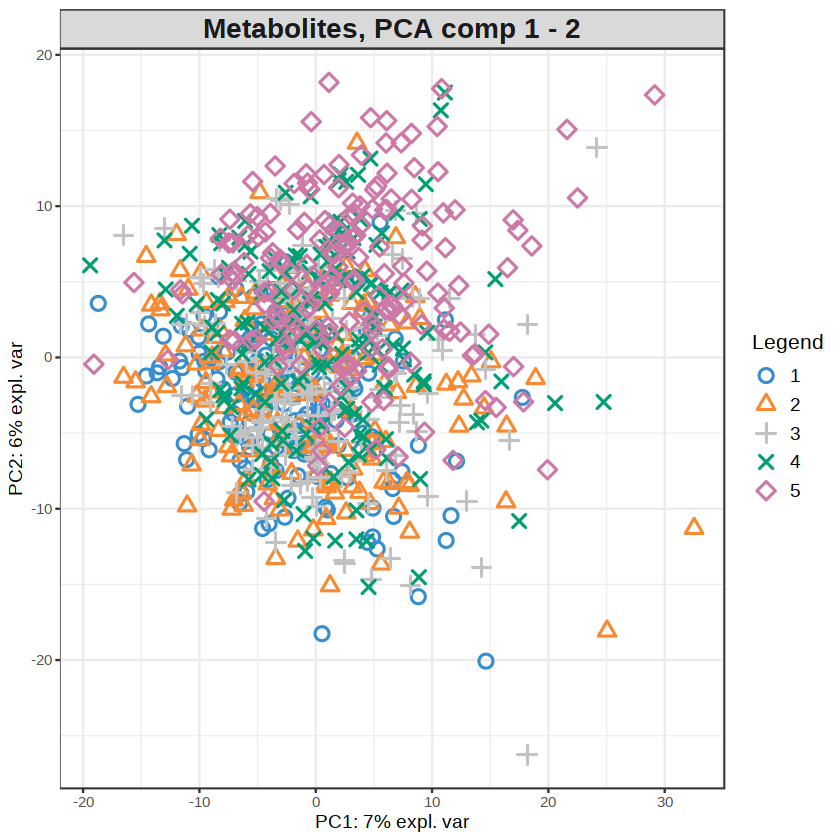

In [132]:
pca.mets <- pca(mets_mat, ncomp = 2, scale = TRUE)

plotIndiv(pca.mets, group = Outcome, ind.names = FALSE,
          legend = TRUE, 
          title = 'Metabolites, PCA comp 1 - 2')

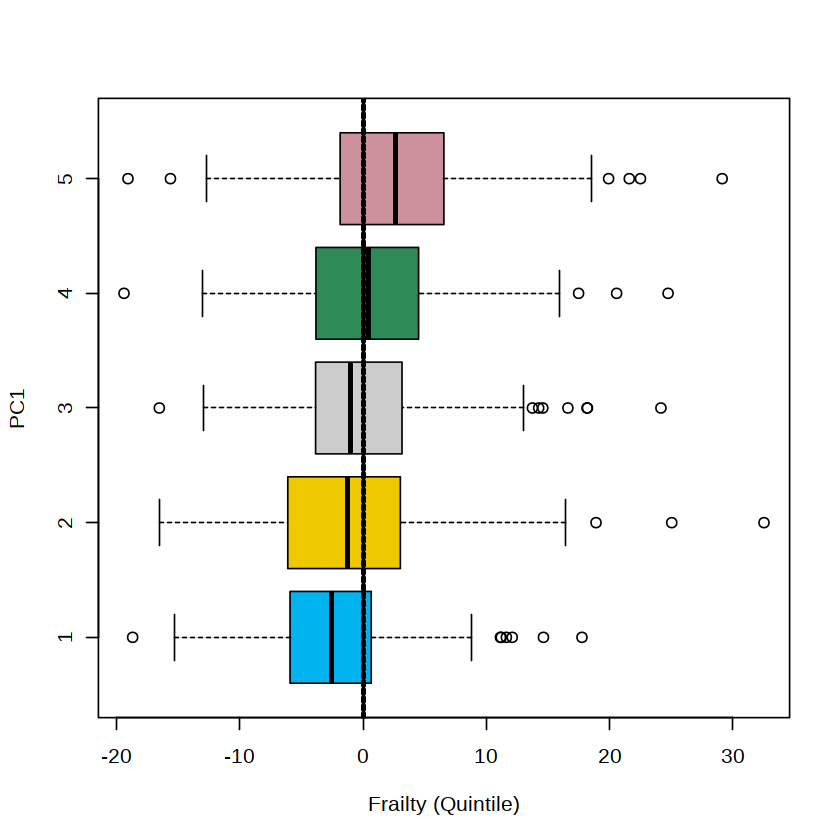

In [153]:
boxplot(split(pca.mets$variates$X[,'PC1'], Outcome),horizontal=TRUE,
        ylab="PC1",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(v=0,lty=2,lwd=3)

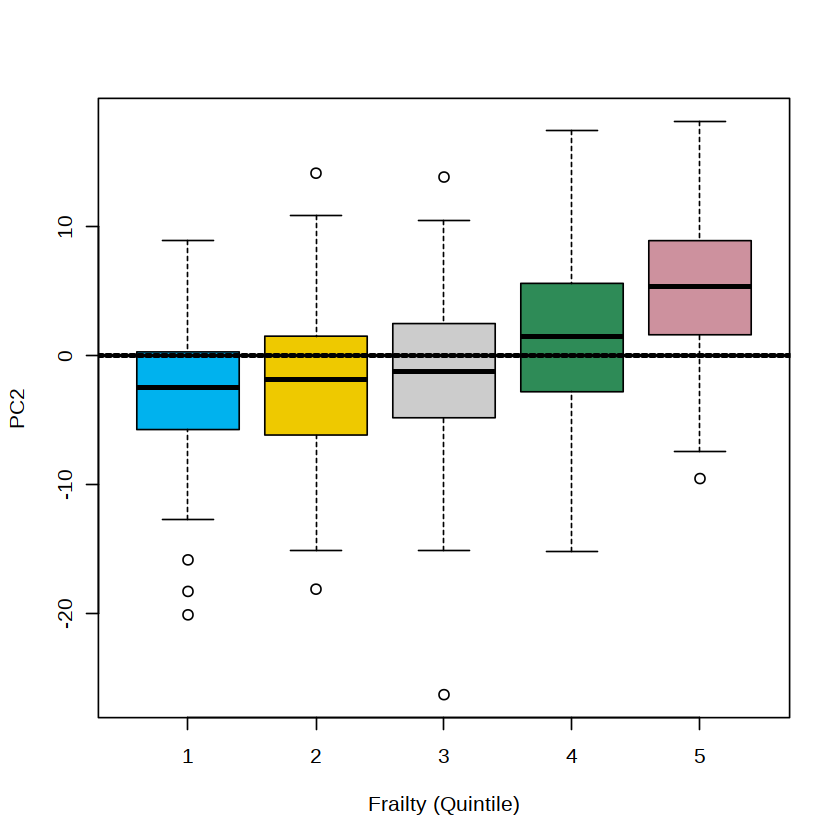

In [154]:
boxplot(split(pca.mets$variates$X[,'PC2'], Outcome),horizontal=FALSE,
        ylab="PC2",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(h=0,lty=2,lwd=3)

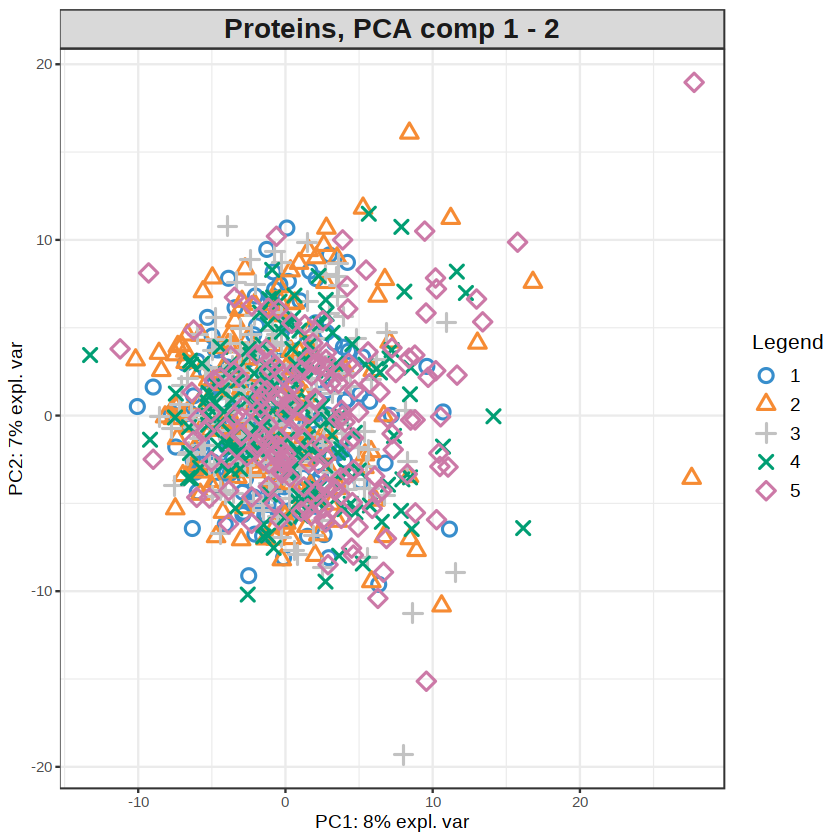

In [155]:
pca.prots <- pca(prots_mat, ncomp = 2, scale = TRUE)

plotIndiv(pca.prots, group = Outcome, ind.names = FALSE,
          legend = TRUE, 
          title = 'Proteins, PCA comp 1 - 2')

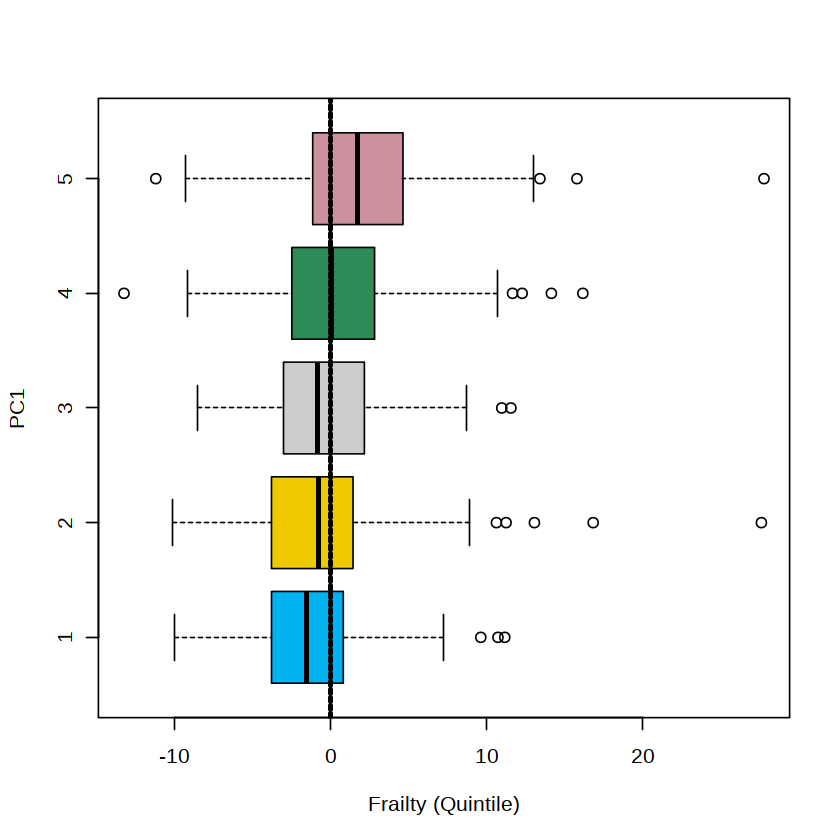

In [156]:
boxplot(split(pca.prots$variates$X[,'PC1'], Outcome),horizontal=TRUE,
        ylab="PC1",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(v=0,lty=2,lwd=3)

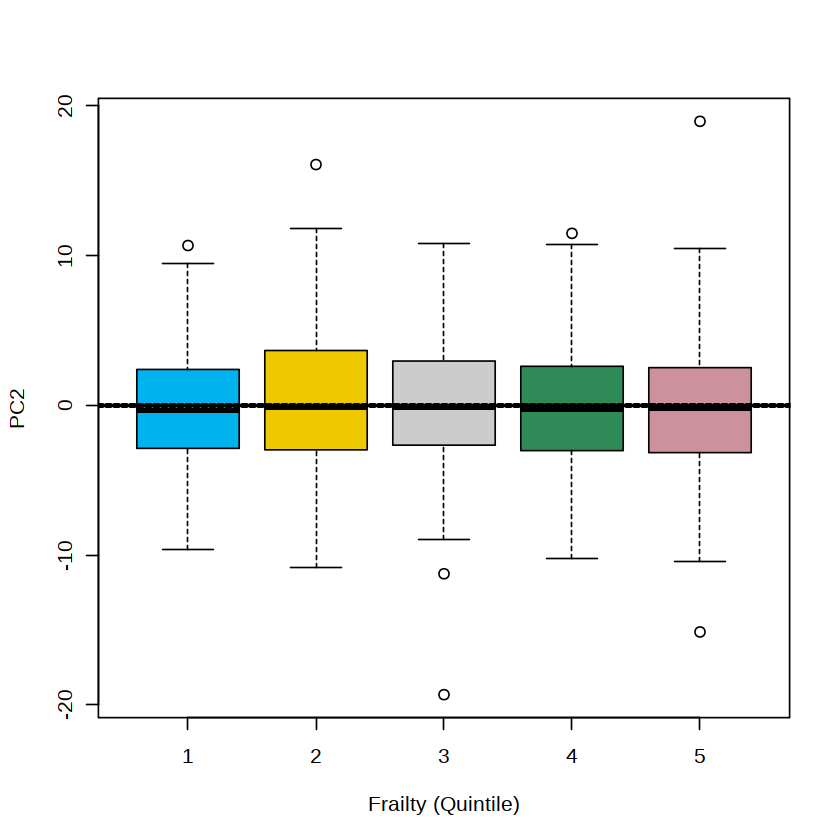

In [157]:
boxplot(split(pca.prots$variates$X[,'PC2'], Outcome),horizontal=FALSE,
        ylab="PC2",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(h=0,lty=2,lwd=3)

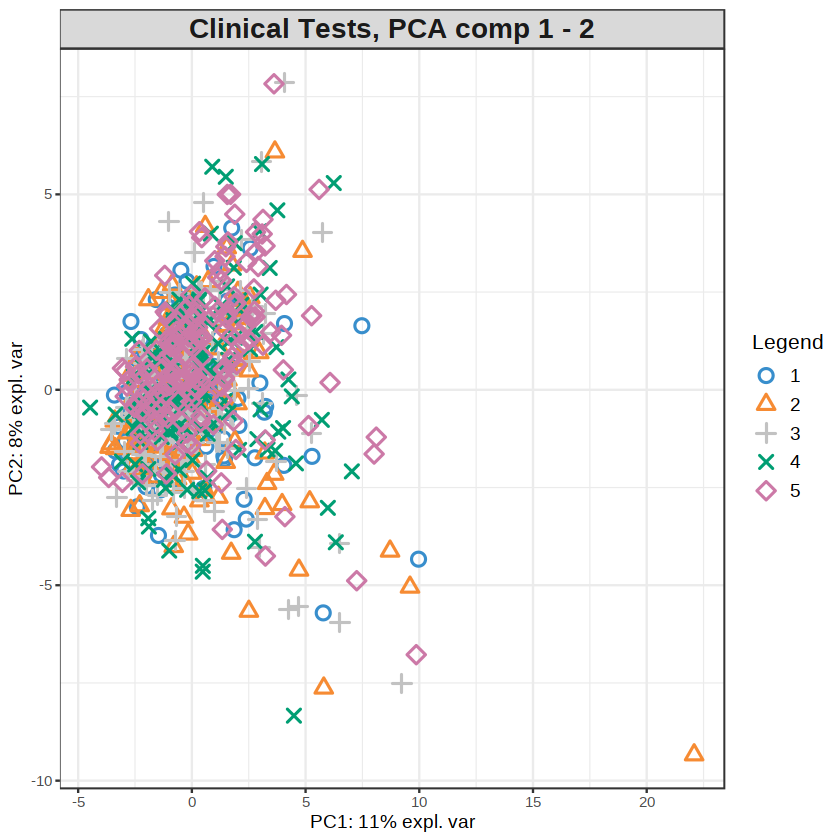

In [158]:
pca.clin <- pca(clin_mat, ncomp = 2, scale = TRUE)

plotIndiv(pca.clin, group = Outcome, ind.names = FALSE,
          legend = TRUE, 
          title = 'Clinical Tests, PCA comp 1 - 2')

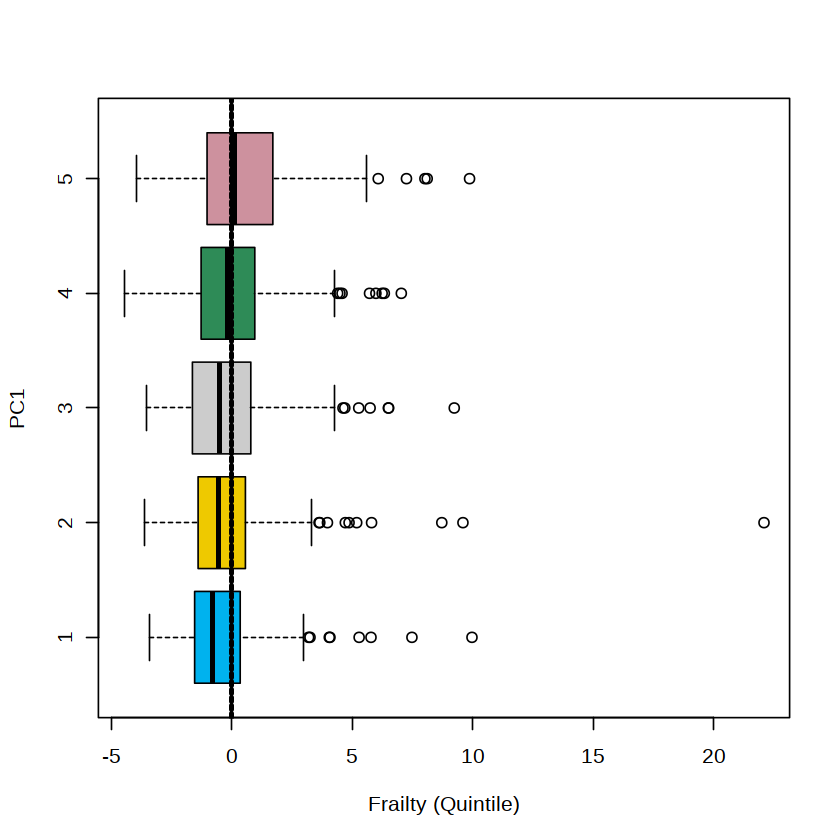

In [159]:
boxplot(split(pca.clin$variates$X[,'PC1'], Outcome),horizontal=TRUE,
        ylab="PC1",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(v=0,lty=2,lwd=3)

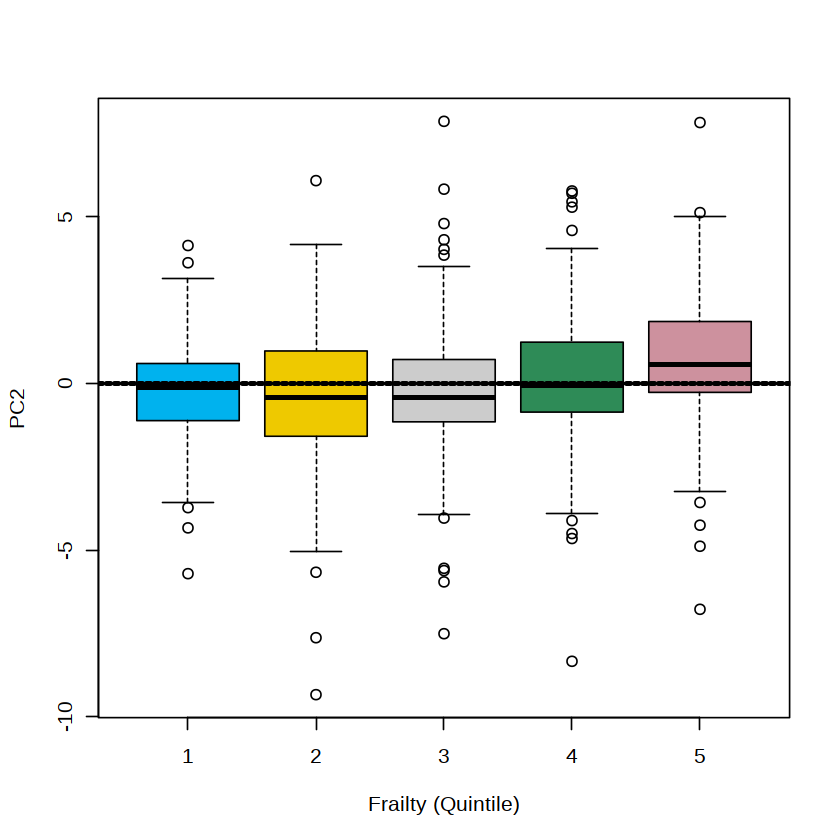

In [160]:
boxplot(split(pca.clin$variates$X[,'PC2'], Outcome),horizontal=FALSE,
        ylab="PC2",xlab="Frailty (Quintile)",
        col=c('deepskyblue2','gold2','gray80','seagreen','pink3'))
abline(h=0,lty=2,lwd=3)

### Metabolites spls



comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%


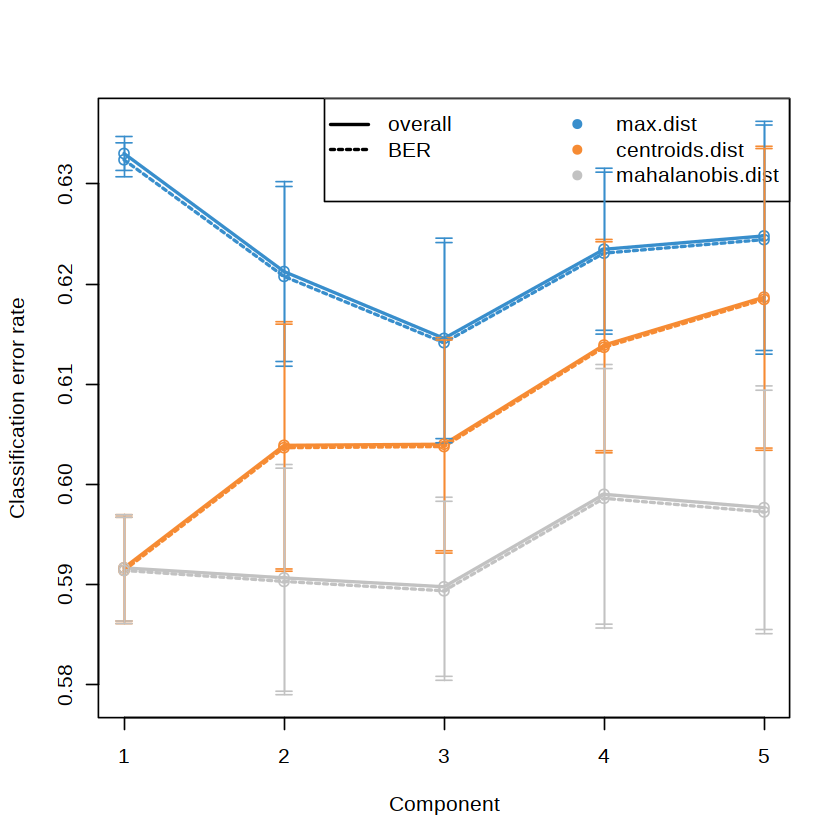

In [58]:
plsda.met <- mixOmics::plsda(mets_mat, Outcome, ncomp = 5)

perf.plsda.met  <- mixOmics::perf(plsda.met, validation = 'Mfold', folds = 3, 
                  progressBar = TRUE,  
                  nrepeat = 10)   ### This is a low number of repeats that should be increased for a better analysis. Its slow. 

plot(perf.plsda.met, sd = TRUE, legend.position = 'horizontal')

In [59]:
# Not great BER
perf.plsda.met


Call:
 perf.mixo_plsda(object = plsda.met, validation = "Mfold", folds = 3, nrepeat = 10, progressBar = TRUE) 

 Main numerical outputs: 
 -------------------- 
 Error rate (overall or BER) for each component and for each distance: see object$error.rate 
 Error rate per class, for each component and for each distance: see object$error.rate.class 
 Prediction values for each component: see object$predict 
 Classification of each sample, for each component and for each distance: see object$class 
 AUC values: see object$auc if auc = TRUE 

 Visualisation Functions: 
 -------------------- 
 plot 

In [70]:
perf.plsda.met$error.rate.class 

,comp1,comp2,comp3,comp4,comp5
1,0.09777778,0.2355556,0.2811111,0.3338889,0.3622222
2,1.00000000,0.9500000,0.9050000,0.8761111,0.8377778
3,1.00000000,0.8727778,0.8122222,0.8094444,0.8094444
4,0.99833333,0.8594444,0.8427778,0.8211111,0.8200000
5,0.06592179,0.1860335,0.2296089,0.2748603,0.2927374
,comp1,comp2,comp3,comp4,comp5
1,0.3855556,0.4350000,0.4455556,0.4788889,0.4583333
2,0.8255556,0.7561111,0.7450000,0.7327778,0.7411111
3,0.7222222,0.7444444,0.7516667,0.7827778,0.7916667
4,0.6633333,0.6922222,0.6838889,0.6605556,0.6844444


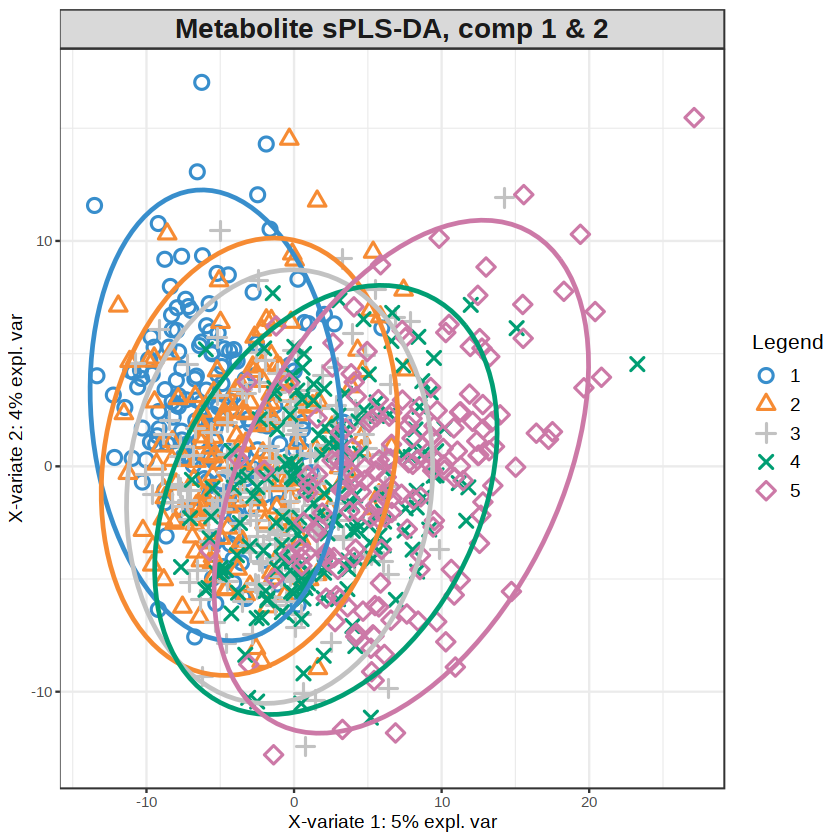

In [63]:
plotIndiv(plsda.met, comp = c(1,2), # plot samples from final model
          group = Outcome, ind.names = FALSE, # colour by class label
          ellipse = TRUE, legend = TRUE, # include 95% confidence ellipse
          title = 'Metabolite sPLS-DA, comp 1 & 2')

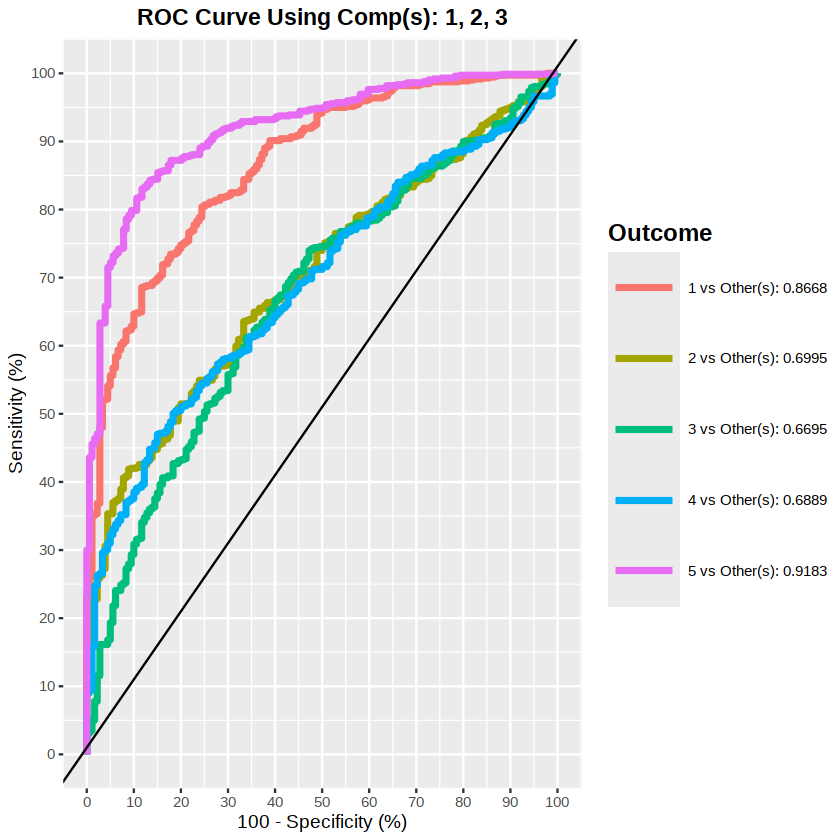

In [62]:
# Overfit model
auroc(plsda.met, roc.comp = 3, print = FALSE)

### Protein splsDA


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%


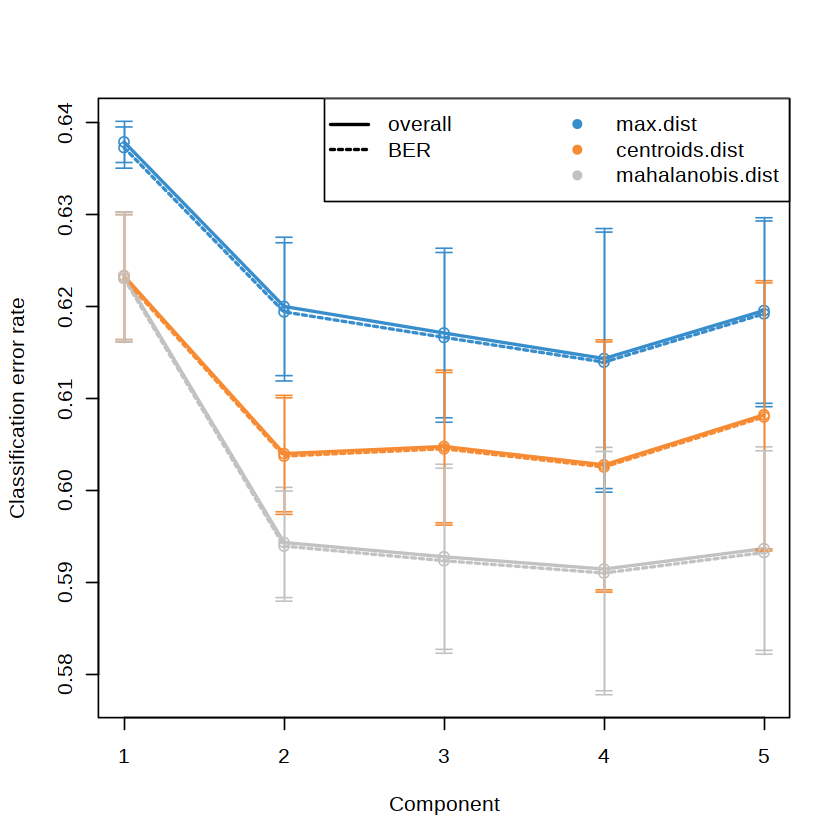

In [64]:
plsda.prots <- mixOmics::plsda(prots_mat, Outcome, ncomp = 5)

perf.plsda.prots  <- mixOmics::perf(plsda.prots, validation = 'Mfold', folds = 3, 
                  progressBar = TRUE,  
                  nrepeat = 10)   ### This is a low number of repeats that should be increased for a better analysis. Its slow. 

plot(perf.plsda.prots, sd = TRUE, legend.position = 'horizontal')

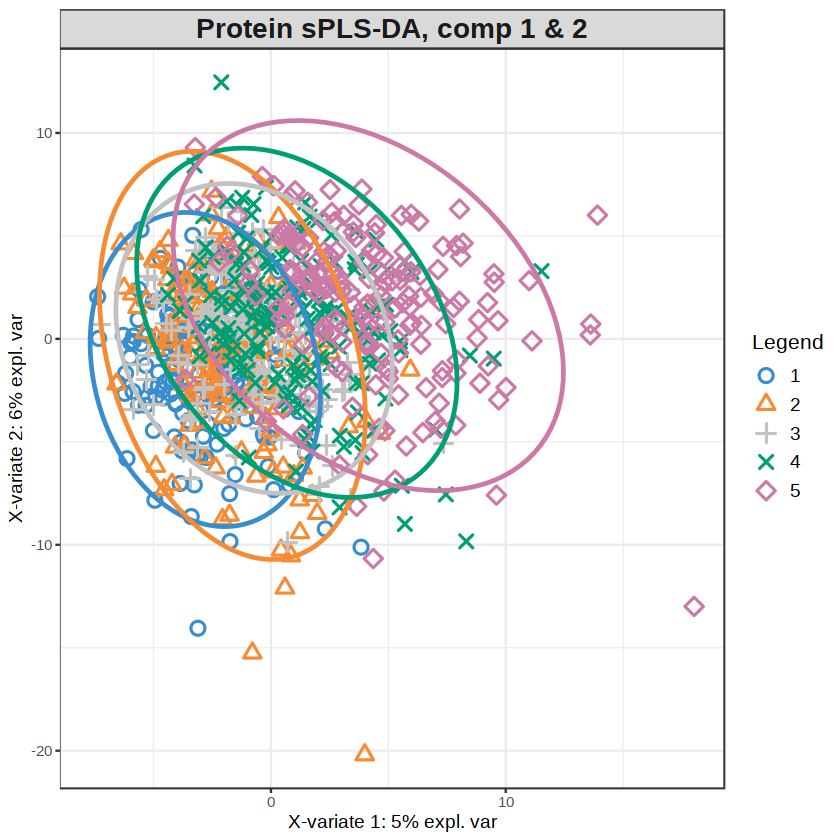

In [65]:
plotIndiv(plsda.prots, comp = c(1,2), # plot samples from final model
          group = Outcome, ind.names = FALSE, # colour by class label
          ellipse = TRUE, legend = TRUE, # include 95% confidence ellipse
          title = 'Protein sPLS-DA, comp 1 & 2')

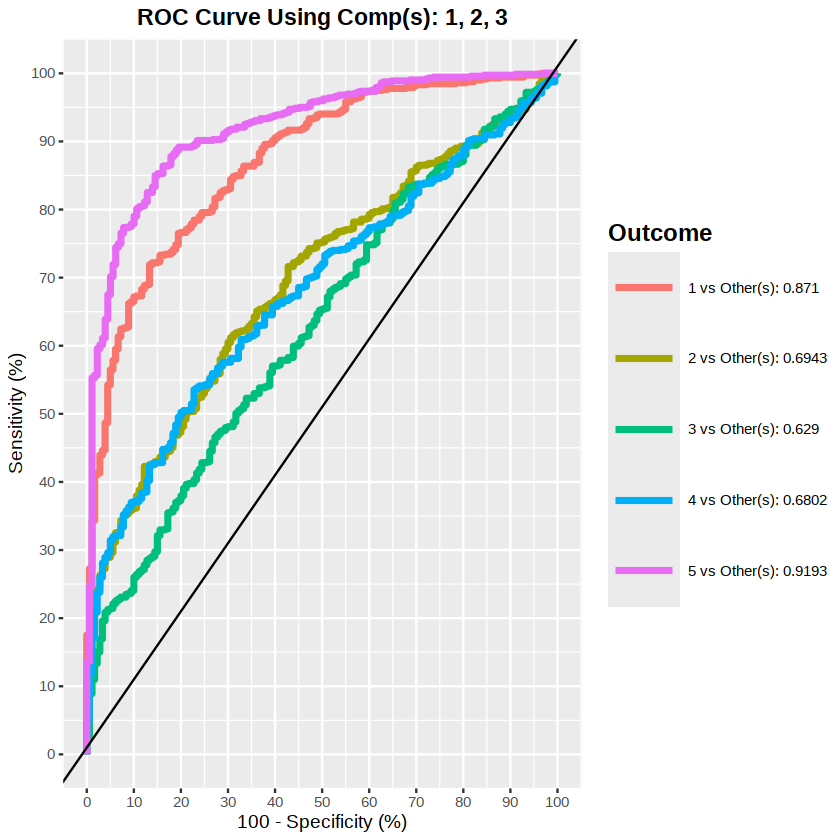

In [66]:
# Overfit model
auroc(plsda.prots, roc.comp = 3, print = FALSE)

### Clinical splsDA


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%


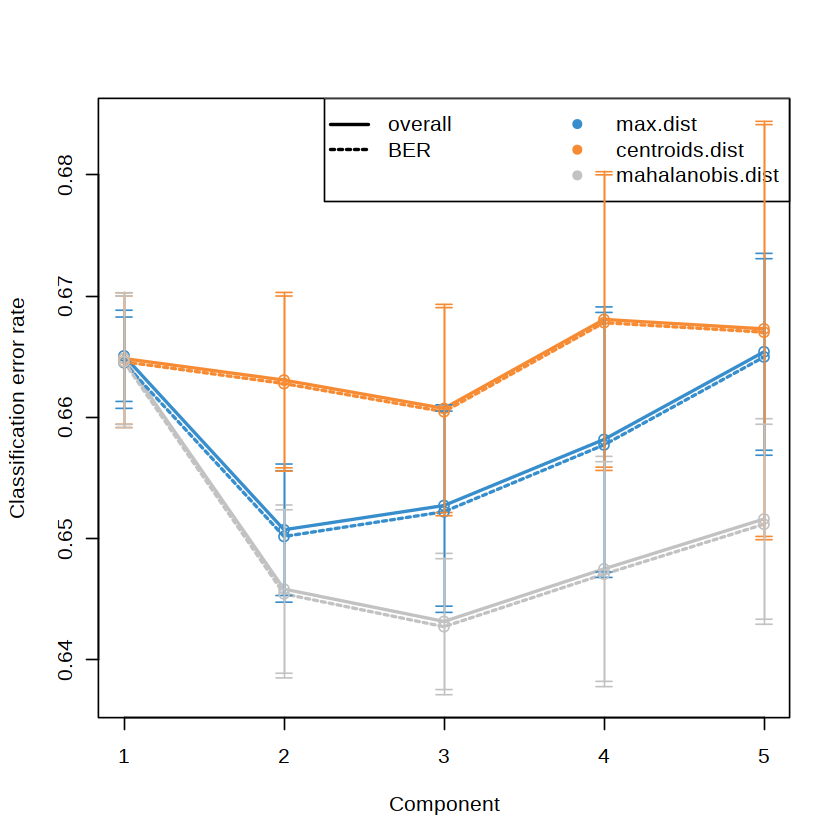

In [67]:
plsda.clin <- mixOmics::plsda(clin_mat, Outcome, ncomp = 5)

perf.plsda.clin  <- mixOmics::perf(plsda.clin, validation = 'Mfold', folds = 3, 
                  progressBar = TRUE,  
                  nrepeat = 10)   ### This is a low number of repeats that should be increased for a better analysis. Its slow. 

plot(perf.plsda.clin, sd = TRUE, legend.position = 'horizontal')

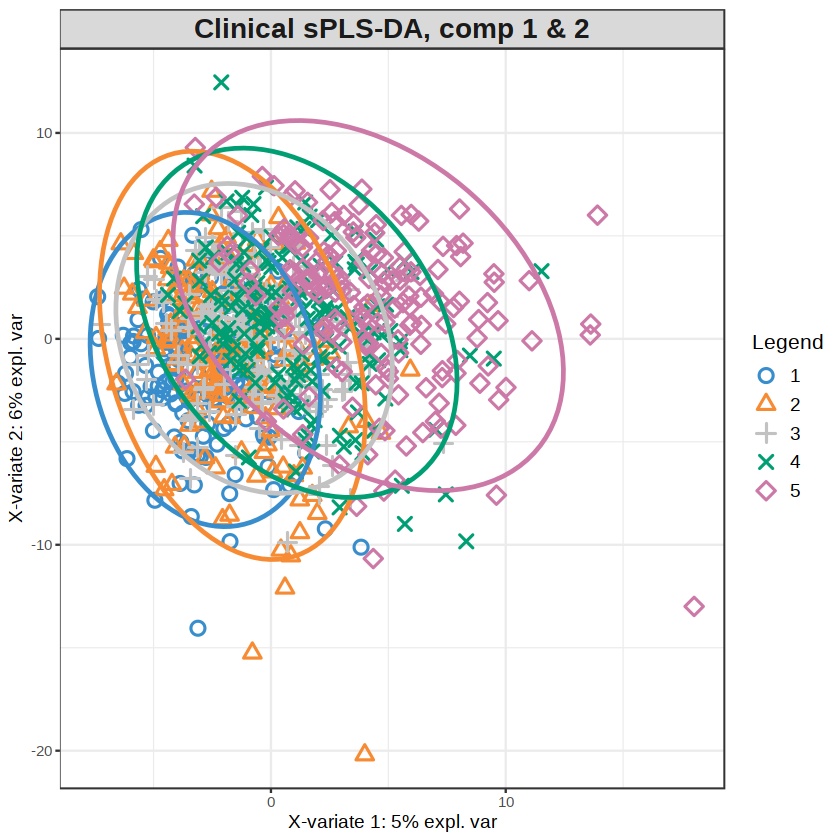

In [68]:
plotIndiv(plsda.prots, comp = c(1,2), # plot samples from final model
          group = Outcome, ind.names = FALSE, # colour by class label
          ellipse = TRUE, legend = TRUE, # include 95% confidence ellipse
          title = 'Clinical sPLS-DA, comp 1 & 2')

# Multiblock plsDA

In [72]:
X <- list(metabolite = mets_mat, 
          protein = prots_mat, 
          clinical = clin_mat)

In [73]:
# Initial design with correlatin of .10
design <- matrix(0.1, ncol = length(X), nrow = length(X), 
                dimnames = list(names(X), names(X)))
diag(design) <- 0
design 

,metabolite,protein,clinical
metabolite,0.0,0.1,0.1
protein,0.1,0.0,0.1
clinical,0.1,0.1,0.0


In [75]:
# For reference this is a highly correlated data set
# Requiring lower correlation in the design leads to higher prediction
res1.pls <- pls(mets_mat, prots_mat, ncomp = 1)
cor(res1.pls$variates$X, res1.pls$variates$Y)

res2.pls <- pls(mets_mat, clin_mat, ncomp = 1)
cor(res2.pls$variates$X, res2.pls$variates$Y)

res3.pls<- pls(prots_mat, clin_mat, ncomp = 1)
cor(res3.pls$variates$X, res3.pls$variates$Y)

,comp1
comp1,0.9699715


,comp1
comp1,0.8908996


,comp1
comp1,0.9301906


Design matrix has changed to include Y; each block will be
            linked to Y.



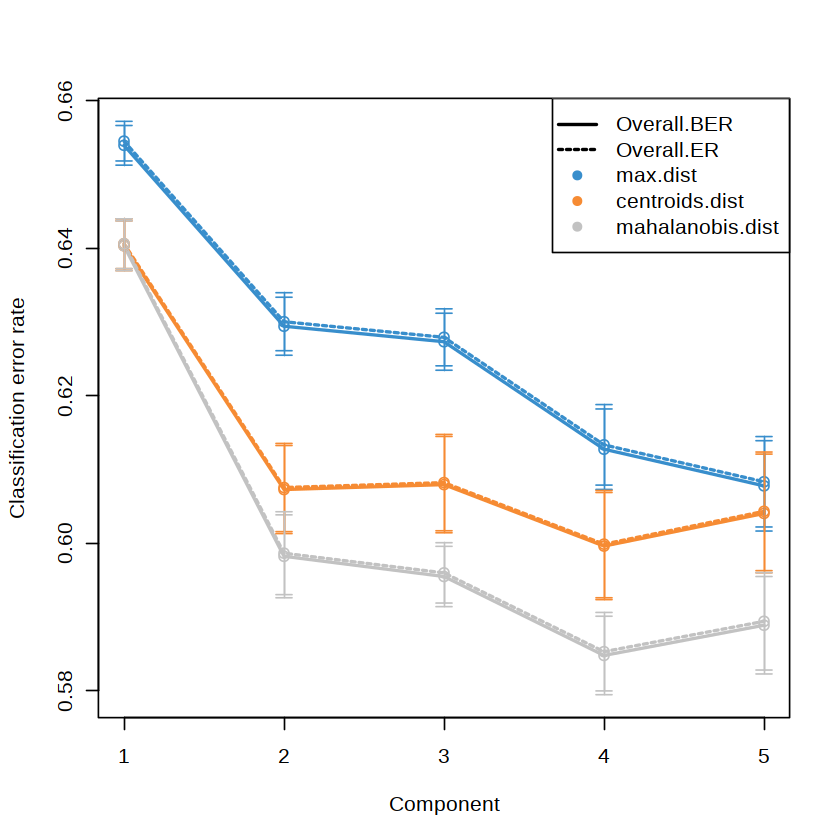

In [77]:
# This takes a long time to run!
diablo.mergeFI <- block.plsda(X, Outcome, ncomp = 5, design = design)

perf.diablo.mergeFI = mixOmics::perf(diablo.mergeFI, validation = 'Mfold', 
                                     progressBar = TRUE,
                                     folds = 10, nrepeat = 10)

# Plot of the error rates based on weighted vote
plot(perf.diablo.mergeFI)

In [78]:
perf.diablo.mergeFI$choice.ncomp$WeightedVote

,max.dist,centroids.dist,mahalanobis.dist
Overall.ER,4,4,4
Overall.BER,4,4,4


In [79]:
ncomp <- perf.diablo.mergeFI$choice.ncomp$WeightedVote["Overall.BER", "centroids.dist"]


In [81]:
# Variable tuning - the number of features to include in each component
# Set the search grid with value of 5 and reduce later

startTime <- Sys.time() 
test.keepX <- list(metabolite = c(seq(5, 25, 5)),
                   protein = c(seq(5, 25, 5)),
                   clinical = c(seq(5, 20, 5)))

tune.diablo.mergeFI <- tune.block.splsda(X, Outcome, ncomp = 2, 
                              test.keepX = test.keepX, design = design,
                              validation = 'Mfold', folds = 10, nrepeat = 1, ### Should update nrepeats with a final model
                              BPPARAM = BiocParallel::SnowParam(workers = 16),
                              dist = "centroids.dist")

list.keepX <- tune.diablo.mergeFI$choice.keepX

endTime <- Sys.time() 
print(endTime - startTime)

Design matrix has changed to include Y; each block will be
            linked to Y.


You have provided a sequence of keepX of length: 5 for block metabolite and 5 for block protein and 4 for block clinical.
This results in 100 models being fitted for each component and each nrepeat, this may take some time to run, be patient!



Time difference of 27.79261 mins


In [88]:
diablo.mergeFI.final <- block.splsda(X, Outcome, ncomp = ncomp, 
                            keepX = list.keepX, design = design)

Design matrix has changed to include Y; each block will be
            linked to Y.



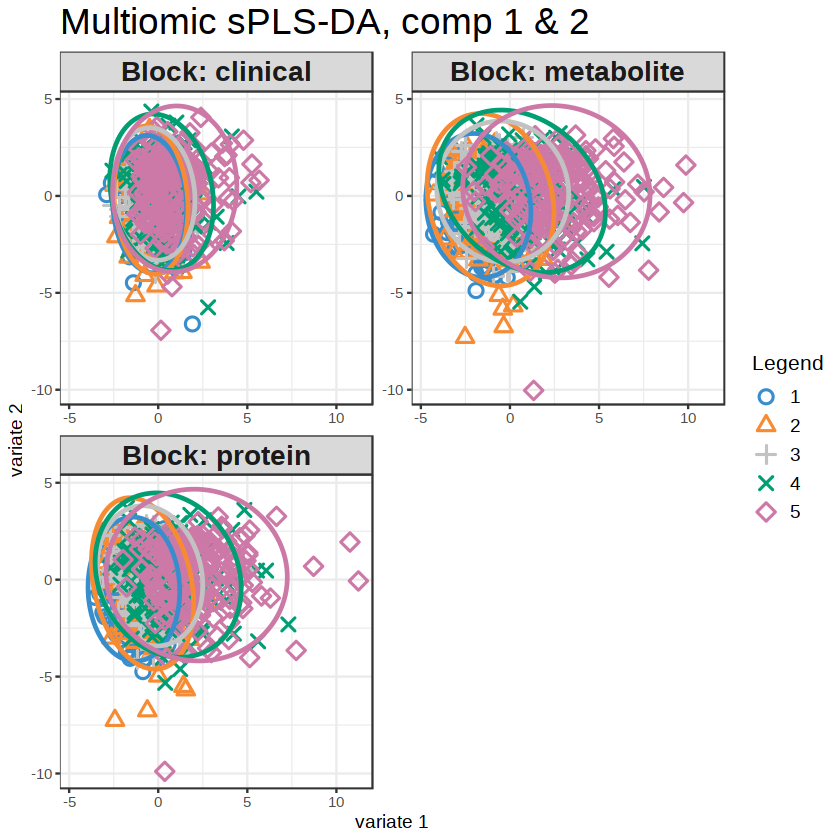

In [89]:
plotIndiv(diablo.mergeFI.final, comp = c(1,2), # plot samples from final model
          group = Outcome, ind.names = FALSE, 
          ellipse = TRUE, legend = TRUE, 
          title = 'Multiomic sPLS-DA, comp 1 & 2')

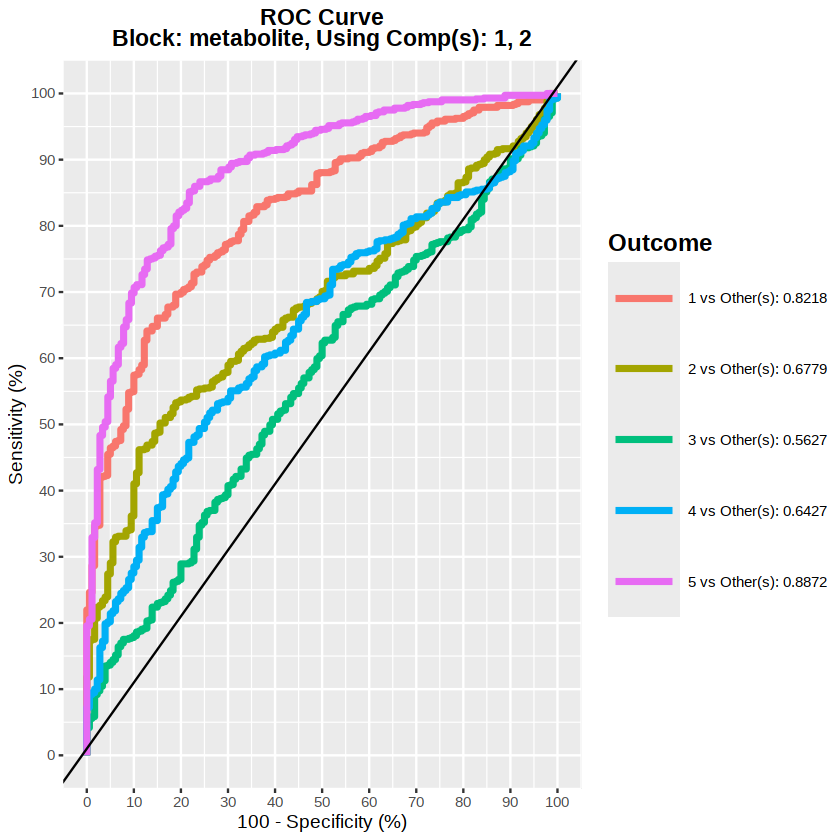

In [93]:
auc.diablo.tcga <- auroc(diablo.mergeFI.final, roc.block = "metabolite", roc.comp = 2,
                   print = FALSE)

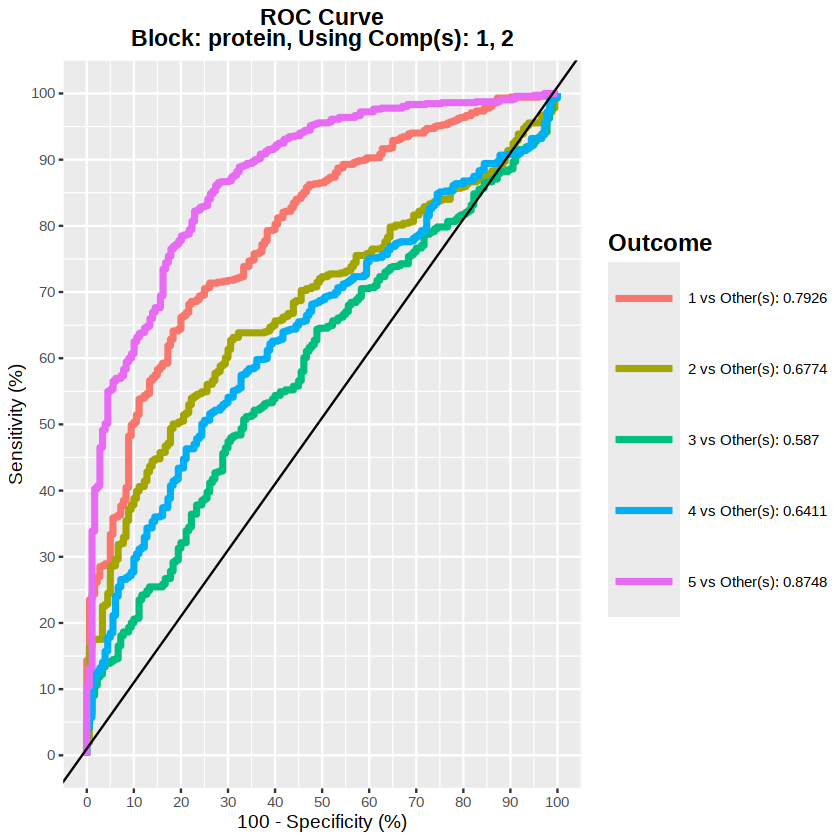

In [94]:
auc.diablo.tcga <- auroc(diablo.mergeFI.final, roc.block = "protein", roc.comp = 2,
                   print = FALSE)

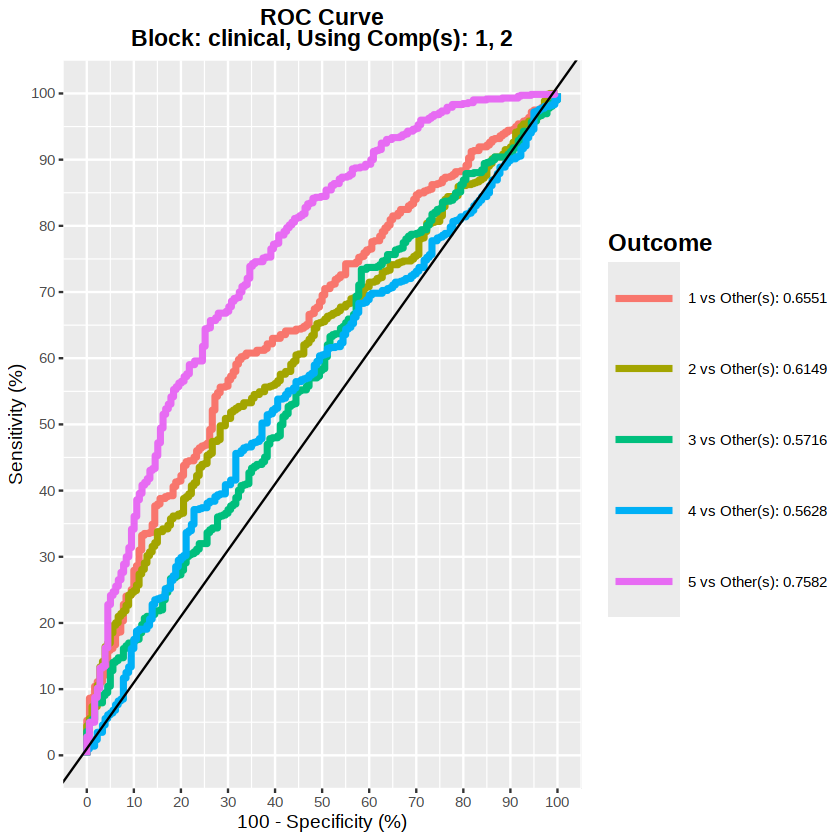

In [95]:
auc.diablo.tcga <- auroc(diablo.mergeFI.final, roc.block = "clinical", roc.comp = 2,
                   print = FALSE)